# PART C: Modelling

This code implements fine-tuning of the XLNet model using the Hugging Face Transformers library on the Financial PhraseBank dataset.

In [2]:
#imports
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset

/Users/priyal/.pyenv/versions/3.9.1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This function `set_seeds(seed)` is used to set random seeds for reproducibility in PyTorch and NumPy. It takes a single argument `seed`, which is used to initialize random number generators.

In [3]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


set_seeds(0)

This code segment loads the "financial_phrasebank" dataset using the `load_dataset` function from the Hugging Face `datasets` library. Next, it splits the dataset into training and validation sets using the `train_test_split` function from scikit-learn. The features (sentences) are stored in `x_train` and `x_valid`, while the corresponding labels are stored in `y_train` and `y_valid`. The split is stratified, with 20% of the data allocated to the validation set and the random seed set to 42 for reproducibility.

In [4]:
dataset = load_dataset("financial_phrasebank", "sentences_50agree")
train_dataset = dataset["train"]
x_train, x_valid, y_train, y_valid = train_test_split(
    train_dataset["sentence"], train_dataset["label"], test_size=0.2, random_state=42
)

print("Trainset:", len(x_train))
print("Validset:", len(x_valid))

Trainset: 3876
Validset: 970


This code defines a custom dataset class named `News`, which is a subclass of `torch.utils.data.Dataset`. The purpose of this class is to encapsulate the training and validation data. In the `__init__` method, it initialises the dataset with two parameters `x` and `y`, which represent the features (sentences) and labels, respectively. The `__getitem__` method retrieves an item from the dataset at the specified `index`. It returns a tuple containing the feature and label corresponding to the given index. The `__len__` method returns the total number of samples in the dataset. After defining the `News` class, instances of this class are created for the training and validation datasets (`trainset` and `validset`, respectively). These instances are initialized with the training and validation data, respectively.

In [5]:
class News(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)


trainset = News(x_train, y_train)
validset = News(x_valid, y_valid)

This code defines a collate function `collate_fn` that processes a batch of data samples. It is intended to be used as the `collate_fn` parameter when creating data loaders in PyTorch.

In [6]:
def collate_fn(batch):
    (x, y) = zip(*batch)
    x = tokenizer(
        x, max_length=512, truncation=True, padding="longest", return_tensors="pt"
    )
    y = {"labels": torch.LongTensor(y)}
    return {**x, **y}

This code segment initializes the XLNet tokenizer, creates data loaders for both the training and validation datasets, sets up the device for computation, initializes the XLNet model for sequence classification, and sets up the optimizer for training.

In [7]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
train_loader = DataLoader(
    trainset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn,
)
valid_loader = DataLoader(
    validset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=3)
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=5e-5)

/Users/priyal/.pyenv/versions/3.9.1/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This function `train(epoch)` is responsible for training the XLNet model for one epoch using the training dataset. 
- `train_loss` and `train_acc` are initialized to keep track of the total loss and accuracy during training.
- `train_pbar = tqdm(train_loader, position=0, leave=True)`: Initialises a progress bar (`tqdm`) to visualize the training progress. It iterates over the batches in the training data loader (`train_loader`).
- `model.train()`: Sets the model to training mode, which enables gradient computation and parameter updates.
- Calculates the average training loss and accuracy for the epoch and returns them.

The function trains the model for one epoch and returns the average loss and accuracy over the entire training dataset.

In [8]:
def train(epoch):
    train_loss, train_acc = 0, 0
    train_pbar = tqdm(train_loader, position=0, leave=True)

    model.train()
    for input_datas in train_pbar:
        for key in input_datas.keys():
            input_datas[key] = input_datas[key].to(device)
        optimizer.zero_grad()
        outputs = model(**input_datas)

        logits = outputs.logits
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        train_pbar.set_description(f"Train Epoch {epoch}")
        train_pbar.set_postfix({"loss": f"{loss:.3f}"})

        pred = torch.argmax(logits, dim=1)
        train_acc += sum(pred == input_datas["labels"])
        train_loss += loss.item()
    return train_loss / len(train_loader), train_acc / len(trainset)

This function `valid(epoch)` is responsible for evaluating the XLNet model on the validation dataset for one epoch. 
- `valid_loss` and `valid_acc` are initialized to keep track of the total loss and accuracy during validation.
- `valid_pbar = tqdm(valid_loader, position=0, leave=True)`: Initializes a progress bar (`tqdm`) to visualize the validation progress. It iterates over the batches in the validation data loader (`valid_loader`).
- `model.eval()`: Sets the model to evaluation mode, which disables gradient computation and parameter updates.
- Calculates the average validation loss and accuracy for the epoch and returns them.

The function evaluates the model on the validation dataset for one epoch and returns the average loss and accuracy over the entire validation dataset.


In [9]:
def valid(epoch):
    valid_loss, valid_acc = 0, 0
    valid_pbar = tqdm(valid_loader, position=0, leave=True)

    model.eval()
    with torch.no_grad():
        for input_datas in valid_pbar:
            for key in input_datas.keys():
                input_datas[key] = input_datas[key].to(device)

            outputs = model(**input_datas)
            logits = outputs.logits
            loss = outputs.loss

            valid_pbar.set_description(f"Valid Epoch {epoch}")
            valid_pbar.set_postfix({"loss": f"{loss:.3f}"})

            pred = torch.argmax(logits, dim=1)
            valid_acc += sum(pred == input_datas["labels"])
            valid_loss += loss.item()

    return valid_loss / len(valid_loader), valid_acc / len(validset)

The training loop runs for 10 epochs. For each epoch:
- It trains the model using the `train(epoch)` function and evaluates it on the validation set using the `valid(epoch)` function.
- The training and validation losses are recorded in the `loss_record` dictionary.
- If the validation accuracy improves over the previous best accuracy, the model's weights are saved.
- The training and validation loss, as well as the best accuracy achieved so far, are printed.
- Finally, the `show_training_loss(loss_record)` function is called to display the loss curves.

Valid Epoch 0: 100%|██████████| 61/61 [00:27<00:00,  2.19it/s, loss=0.057]


Saving Model With Acc 0.84845
Train Loss: 0.64205 Train Acc: 0.72833| Valid Loss: 0.37448 Valid Acc: 0.84845| Best Acc: 0.84845



Valid Epoch 1: 100%|██████████| 61/61 [00:28<00:00,  2.16it/s, loss=0.115]


Saving Model With Acc 0.85155
Train Loss: 0.33547 Train Acc: 0.87410| Valid Loss: 0.36609 Valid Acc: 0.85155| Best Acc: 0.85155



Valid Epoch 2: 100%|██████████| 61/61 [00:28<00:00,  2.15it/s, loss=0.015]


Train Loss: 0.20379 Train Acc: 0.92647| Valid Loss: 0.47820 Valid Acc: 0.82680| Best Acc: 0.85155



Valid Epoch 3: 100%|██████████| 61/61 [00:29<00:00,  2.09it/s, loss=0.148]


Train Loss: 0.13512 Train Acc: 0.95175| Valid Loss: 0.40765 Valid Acc: 0.84948| Best Acc: 0.85155



Valid Epoch 4: 100%|██████████| 61/61 [00:28<00:00,  2.12it/s, loss=0.199]


Train Loss: 0.09427 Train Acc: 0.97085| Valid Loss: 0.49957 Valid Acc: 0.84639| Best Acc: 0.85155



Valid Epoch 5: 100%|██████████| 61/61 [00:30<00:00,  2.03it/s, loss=0.280]


Saving Model With Acc 0.87423
Train Loss: 0.07596 Train Acc: 0.97833| Valid Loss: 0.48459 Valid Acc: 0.87423| Best Acc: 0.87423



Valid Epoch 6: 100%|██████████| 61/61 [00:28<00:00,  2.12it/s, loss=0.524]


Train Loss: 0.06989 Train Acc: 0.97678| Valid Loss: 0.58956 Valid Acc: 0.84639| Best Acc: 0.87423



Valid Epoch 7: 100%|██████████| 61/61 [00:28<00:00,  2.15it/s, loss=0.242]


Train Loss: 0.06042 Train Acc: 0.98271| Valid Loss: 0.60409 Valid Acc: 0.86495| Best Acc: 0.87423



Valid Epoch 8: 100%|██████████| 61/61 [00:29<00:00,  2.10it/s, loss=0.001]


Train Loss: 0.05745 Train Acc: 0.98065| Valid Loss: 0.76607 Valid Acc: 0.84227| Best Acc: 0.87423



Valid Epoch 9: 100%|██████████| 61/61 [00:27<00:00,  2.24it/s, loss=0.573]

Train Loss: 0.05145 Train Acc: 0.98504| Valid Loss: 0.63741 Valid Acc: 0.86701| Best Acc: 0.87423



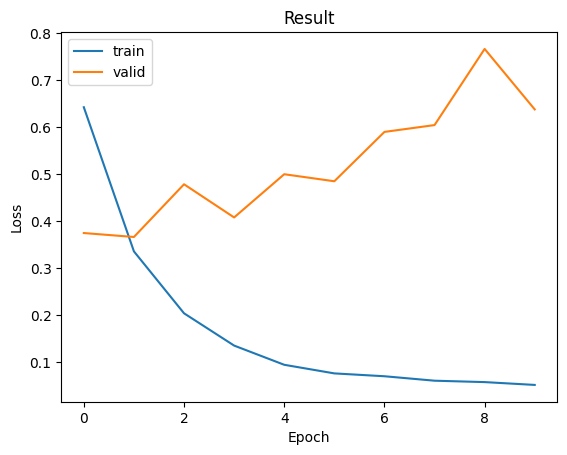

In [10]:
def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()]

    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.title("Result")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["train", "valid"], loc="upper left")
    plt.show()


best_acc = 0
loss_record = {"train": [], "valid": []}

for epoch in range(10):
    train_loss, train_acc = train(epoch)
    valid_loss, valid_acc = valid(epoch)

    loss_record["train"].append(train_loss)
    loss_record["valid"].append(valid_loss)

    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), "xlnet_model.ckpt")
        print(f"Saving Model With Acc {best_acc:.5f}")

    print(f"Train Loss: {train_loss:.5f} Train Acc: {train_acc:.5f}", end="| ")
    print(f"Valid Loss: {valid_loss:.5f} Valid Acc: {valid_acc:.5f}", end="| ")
    print(f"Best Acc: {best_acc:.5f}", end="\n\n")

show_training_loss(loss_record)

In the last epoch of training, the model achieved a relatively high training accuracy of approximately 98.50% and a validation accuracy of about 86.70%. The training loss was quite low at 0.05145, indicating that the model's predictions on the training data were very close to the actual labels. However, the validation loss was higher at 0.63741, suggesting that the model may be overfitting to some extent as it is not generalizing as well to unseen validation data.